<a href="https://colab.research.google.com/github/geethikashine/Airbnb-Price-Predictor/blob/main/Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load the CSV file to inspect its structure and data
airbnb_data = pd.read_csv("airbnbData.csv", encoding='latin1')

# Display basic information about the dataset
print("Dataset Info:")
print(airbnb_data.info())
print("First Few Rows:")
print(airbnb_data.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2022 entries, 0 to 2021
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ListingID              2022 non-null   int64  
 1   Title                  2022 non-null   object 
 2   UserID                 2022 non-null   int64  
 3   baseurl                2022 non-null   object 
 4   Price                  2022 non-null   int64  
 5   AboutListing           2019 non-null   object 
 6   HostName               2022 non-null   object 
 7   MemberDate             2022 non-null   object 
 8   Lat                    2022 non-null   float64
 9   Long                   2022 non-null   float64
 10  BookInstantly          2022 non-null   object 
 11  Cancellation           2022 non-null   object 
 12  PageCounter            2022 non-null   int64  
 13  PageNumber             2022 non-null   int64  
 14  A_AC                   2022 non-null   int

In [2]:
def clean_price(value):
    """
    Cleans price-related columns by removing non-numeric characters and converting to float.
    """
    try:
        return float(str(value).replace('$', '').replace(',', '').strip())
    except ValueError:
        return None

def clean_numeric(value):
    """
    Converts a value to float if possible; else returns None.
    """
    try:
        return float(value)
    except ValueError:
        return None

def clean_and_impute(data):
    """
    Cleans and imputes missing values in numeric columns.
    """
    # Clean price-related columns
    data['Price'] = data['Price'].apply(clean_price)
    data['P_Cleaning'] = data['P_Cleaning'].apply(clean_price)
    data['S_Bathrooms'] = data['S_Bathrooms'].apply(clean_numeric)
    data['S_Bedrooms'] = data['S_Bedrooms'].apply(clean_numeric)
    data['S_NumBeds'] = data['S_NumBeds'].apply(clean_numeric)

    # Replace infinite values with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Impute missing numeric values with mean
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        data[col].fillna(data[col].mean(), inplace=True)
    return data

airbnb_data = clean_and_impute(airbnb_data)
print("Data Cleaning Completed.")


Data Cleaning Completed.


<ipython-input-2-9e58a9f610fc>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [3]:
def feature_engineering(data):
    """
    Creates derived features for the dataset.
    Handles potential division by zero errors.
    """
    # Replace 0 with 1 to avoid division by zero and inf values
    data['Price_per_Bedroom'] = data['Price'] / data['S_Bedrooms'].replace(0, 1)
    data['Price_per_Bathroom'] = data['Price'] / data['S_Bathrooms'].replace(0, 1)
    data['Price_per_Bed'] = data['Price'] / data['S_NumBeds'].replace(0, 1)

    # Handle newly introduced NaN values (including those from division by zero)
    derived_columns = ['Price_per_Bedroom', 'Price_per_Bathroom', 'Price_per_Bed']
    for col in derived_columns:
        data[col].fillna(data[col].mean(), inplace=True)  # Impute NaN with mean
    return data

airbnb_data = clean_and_impute(airbnb_data)
airbnb_data = feature_engineering(airbnb_data)
print("Feature Engineering Completed.")

Feature Engineering Completed.


<ipython-input-2-9e58a9f610fc>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
<ipython-input-3-ef900af24d8b>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [4]:
# Define features and target variable
features = ['S_Bathrooms', 'S_Bedrooms', 'S_NumBeds', 'P_Cleaning',
            'Price_per_Bedroom', 'Price_per_Bathroom', 'Price_per_Bed']
target = 'Price'

X = airbnb_data[features]
y = airbnb_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data Splitting Completed.")


Data Splitting Completed.


In [5]:
def feature_engineering(data):
    """
    Creates derived features for the dataset.
    Handles potential division by zero errors.
    """
    data['Price_per_Bedroom'] = data['Price'] / data['S_Bedrooms'].replace(0, np.nan)  # Replace 0 with NaN to avoid division by zero
    data['Price_per_Bathroom'] = data['Price'] / data['S_Bathrooms'].replace(0, np.nan)  # Replace 0 with NaN to avoid division by zero
    data['Price_per_Bed'] = data['Price'] / data['S_NumBeds'].replace(0, np.nan)  # Replace 0 with NaN to avoid division by zero

    # Handle newly introduced NaN values (including those from division by zero)
    derived_columns = ['Price_per_Bedroom', 'Price_per_Bathroom', 'Price_per_Bed']
    for col in derived_columns:
        data[col].fillna(data[col].mean(), inplace=True)  # Impute NaN with mean
    return data

airbnb_data = feature_engineering(airbnb_data)
print("Feature Engineering Completed.")

Feature Engineering Completed.


<ipython-input-5-1d0f2b27a296>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)  # Impute NaN with mean


In [6]:
# Hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Retrieve the best model
model = grid_search.best_estimator_
print("Best Model:", model)


Best Model: RandomForestRegressor(max_depth=10, random_state=42)


In [7]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 1567.9031658174513
R² Score: 0.8375741048495213


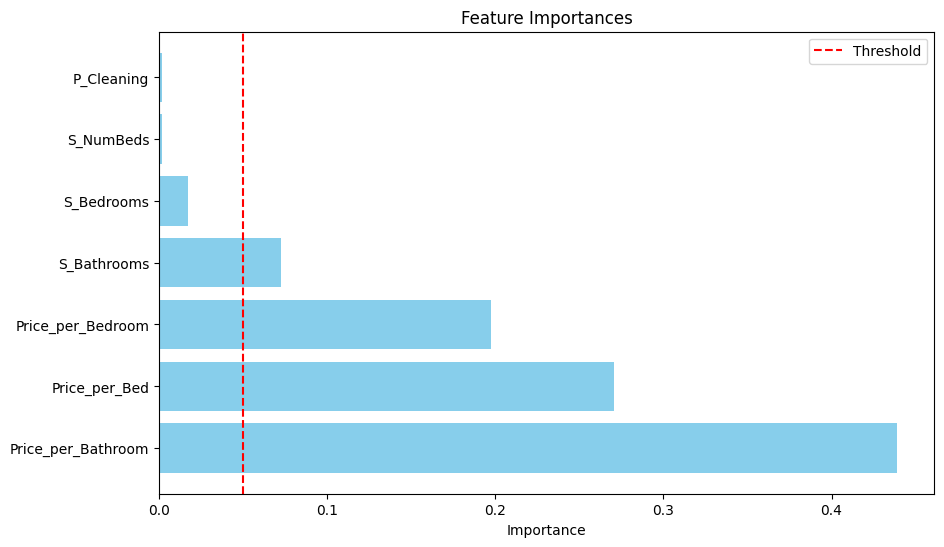

In [8]:
# Visualize feature importance
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
importance_sorted = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)
features_sorted, importances_sorted = zip(*importance_sorted)
plt.barh(features_sorted, importances_sorted, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.axvline(x=0.05, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.show()


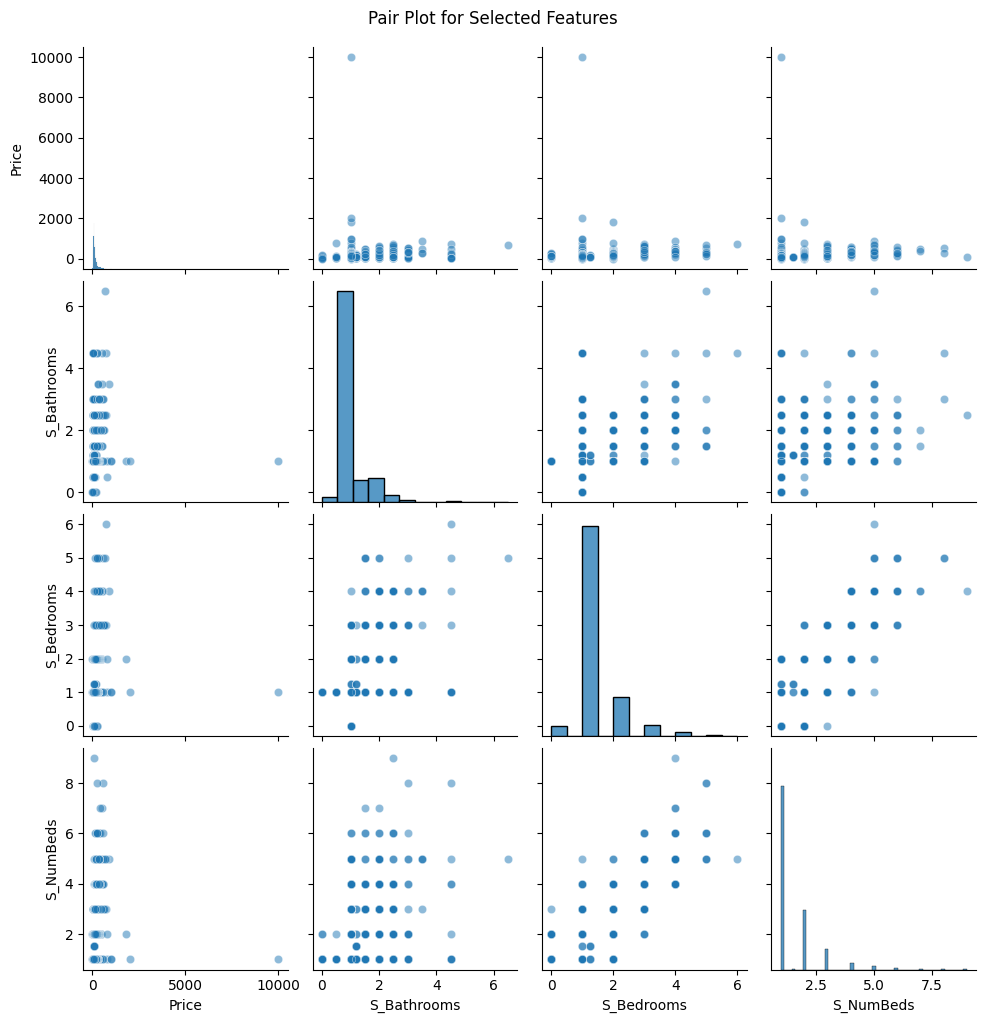

In [17]:
# Pair Plots
def plot_pairwise_relationships(data, features, target):
    """
    Creates pair plots to study relationships between features and the target.
    """
    selected_features = ['Price', 'S_Bathrooms', 'S_Bedrooms', 'S_NumBeds']
    sns.pairplot(airbnb_data[selected_features], plot_kws={'alpha': 0.5})
    plt.suptitle("Pair Plot for Selected Features", y=1.02)
    plt.show()

plot_pairwise_relationships(airbnb_data, features, target)

In [9]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validated R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores)}")


Cross-Validated R² Scores: [0.80195153 0.96525144 0.77298301 0.94975663 0.32846514]
Mean R² Score: 0.7636815498935483


In [10]:
# Save the trained model
joblib.dump(model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'.")

# Load the model for future use
loaded_model = joblib.load('random_forest_model.pkl')
print("Model loaded successfully.")


Model saved as 'random_forest_model.pkl'.
Model loaded successfully.


In [11]:
def predict_price(new_data, model):
    """
    Predict the price for new Airbnb listings.
    """
    required_columns = ['S_Bathrooms', 'S_Bedrooms', 'S_NumBeds', 'P_Cleaning',
                        'Price_per_Bedroom', 'Price_per_Bathroom', 'Price_per_Bed']
    missing_cols = [col for col in required_columns if col not in new_data.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in input data: {missing_cols}")
    return model.predict(new_data)

# Example usage
new_listing = pd.DataFrame([{
    'S_Bathrooms': 2,
    'S_Bedrooms': 3,
    'S_NumBeds': 4,
    'P_Cleaning': 50,
    'Price_per_Bedroom': 100,
    'Price_per_Bathroom': 150,
    'Price_per_Bed': 80
}])

predicted_price = predict_price(new_listing, loaded_model)
print(f"Predicted Price for New Listing: {predicted_price[0]}")


Predicted Price for New Listing: 300.1427520965017
